### Importing Libraries

In [1]:
# Importing libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
import joblib
import json

/var/folders/89/cgd27rls2tqb1xj6_7kglkbc0000gn/T/ipykernel_14074/531554718.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Reading Config File and Sample Data

In [2]:
# Reading configuration file
config_path = "../configs/config.json"

with open(config_path, 'r') as json_file:
    config = json.load(json_file)

In [15]:
# Reading csv file from the designated path
# Since the notebook takes relative paths from its own position, we will be updating the path
data = pd.read_csv(f"../{config['data_path']}")
data.head()

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


### Analysing Data / Preprocessing

In [16]:
# Lets check the unique labels in the dataset and the total length of dataset
data.label.unique().tolist(), len(data.label.unique()), data.shape

(['ft', 'mr', 'ct', 'pkg', 'ch', 'cnc', nan], 7, (37295, 2))

In [17]:
# The data contains nan values so lets analyse those
print("Total Nan Values in the dataset", data.isna().sum().sum())
print("Total Dataset:", data.shape[0])

Total Nan Values in the dataset 100
Total Dataset: 37295


In [18]:
# There are only 100 nan values in the dataset consisting of 37295 rows
# We can simply drop these values
preprocessed_data = data.dropna()
print("Dataset Length after dropping rows containg nan:", preprocessed_data.shape[0])

Dataset Length after dropping rows containg nan: 37195


In [19]:
preprocessed_data.label.unique().tolist(), len(preprocessed_data.label.unique())

(['ft', 'mr', 'ct', 'pkg', 'ch', 'cnc'], 6)

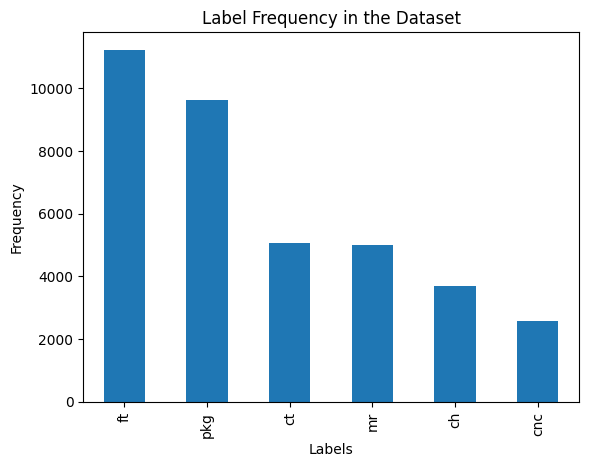

In [20]:
import matplotlib.pyplot as plt

# Plotting the frequency of each label
label_counts = preprocessed_data['label'].value_counts()
label_counts.plot(kind='bar')

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Frequency in the Dataset')

# Showing the plot
plt.show()

### Train/Test Splitting, Vectorizing input using TFIDF 

In [21]:
# Split the Data into 30% Test and 70% Train
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data['text'], preprocessed_data['label'], test_size=0.3, random_state=41)

# Initiating TFIDF Vectorizer
TF_IDF = TfidfVectorizer()

# Training the Vectorizer
TF_IDF.fit(X_train)
X_train_tfidf = TF_IDF.transform(X_train)

# Saving the TF-IDF model to be used for the API for prediction
tfidf_model_path = f"../{config['model_path']}tfidf_model.joblib"
joblib.dump(TF_IDF, tfidf_model_path)

X_test_tfidf = TF_IDF.transform(X_test)

### Using SVM Model and calculating the accuracy

In [22]:
# Initializing and training a Linear SVC classifier
SVM = LinearSVC(dual=False)
SVM.fit(X_train_tfidf, y_train)

# Saving the SVM model to be used for the API for prediction
svm_model_path = f"../{config['model_path']}svm_model.joblib"
joblib.dump(SVM, svm_model_path)

# Predicting and evaluating LinearSVC classifier
SVM_Prediction = SVM.predict(X_test_tfidf)
print('\nSVM Classifier Performance:')
print('Accuracy:', metrics.accuracy_score(y_test, SVM_Prediction))
print('F1 Score:', metrics.f1_score(y_test, SVM_Prediction, pos_label='science', average='micro'))



SVM Classifier Performance:
Accuracy: 0.887445111569137
F1 Score: 0.887445111569137


/Users/aliather/Desktop/test_pipeline/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1549: UserWarning: Note that pos_label (set to 'science') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


### BERT Approach

#### The model could be fine tuned on my mahcine (Macbook Air M1). The model was fine tuned on google colab with this dataset, and gave 89% accuracy, which was very close to the SVC. The following code is just an example of how the BERT model could be used. A very limited dataset (100 rows) are being used for this model (performance issues).
### NOTE: The following code is not completely written be me, some of it is taken from the internet. I altered the code according to my needs. 

In [23]:
data = preprocessed_data[:100]

In [24]:
import torch
# Using gpu
device = torch.device('mps')

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Converting 'label' column to numeric form
data['label_numeric'] = label_encoder.fit_transform(data['label'])
# Splitting the Data into 30% Test and 70% Train
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label_numeric'], test_size=0.3, random_state=42)

# Initializing BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
model.to(device)

# Tokenizing and padding sequences
max_length = 128
X_train_tokenized = tokenizer(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
X_test_tokenized = tokenizer(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Converting labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).to(device)

# Creating TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tokenized['input_ids'], X_train_tokenized['attention_mask'], y_train_tensor)
test_dataset = TensorDataset(X_test_tokenized['input_ids'], X_test_tokenized['attention_mask'], y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Setting hyperparameters
learning_rate = 2e-5
epochs = 10

# Initializing the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Fine-tuning the BERT model
for epoch in tqdm(range(epochs)):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids.to(device), attention_mask=attention_mask.to(device), labels=labels.to(device))
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}')

# Testing the fine-tuned model
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids.to(device), attention_mask=attention_mask.to(device))
        _, predicted = torch.max(outputs.logits, 1)
        total_correct += (predicted == labels.to(device)).sum().item()
        total_samples += labels.size(0)

print(total_correct, total_samples)
accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/var/folders/89/cgd27rls2tqb1xj6_7kglkbc0000gn/T/ipykernel_14074/2186387771.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_numeric'] = label_encoder.fit_transform(data['label'])
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/aliather/Desktop/test_pipeline/venv/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or se

Epoch [1/10], Loss: 1.7894


 20%|██        | 2/10 [00:04<00:16,  2.08s/it]

Epoch [2/10], Loss: 1.6987


 30%|███       | 3/10 [00:05<00:13,  1.89s/it]

Epoch [3/10], Loss: 1.6569


 40%|████      | 4/10 [00:07<00:10,  1.81s/it]

Epoch [4/10], Loss: 1.6936


 50%|█████     | 5/10 [00:09<00:08,  1.70s/it]

Epoch [5/10], Loss: 1.5455


 60%|██████    | 6/10 [00:10<00:06,  1.65s/it]

Epoch [6/10], Loss: 1.4833


 70%|███████   | 7/10 [00:12<00:04,  1.62s/it]

Epoch [7/10], Loss: 1.4504


 80%|████████  | 8/10 [00:13<00:03,  1.57s/it]

Epoch [8/10], Loss: 1.4025


 90%|█████████ | 9/10 [00:15<00:01,  1.57s/it]

Epoch [9/10], Loss: 1.2838


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

Epoch [10/10], Loss: 1.4193
12 30
Test Accuracy: 40.00%
